In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
import tensorflow as tf
import numpy as np

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [4]:
dataset = datasets.PubMedDiabetes()
display(HTML(dataset.description))
G, _ = dataset.load()

In [5]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 44338

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [44338]
        Weights: all 1 (default)


In [6]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

Removed 1000 edges
Removed 2000 edges
Removed 3000 edges
Removed 4000 edges
Sampled 1000 negative examples
Sampled 2000 negative examples
Sampled 3000 negative examples
Sampled 4000 negative examples
** Sampled 4433 positive and 4433 negative edges. **


In [7]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

Removed 1000 edges
Removed 2000 edges
Removed 3000 edges
Sampled 1000 negative examples
Sampled 2000 negative examples
Sampled 3000 negative examples
** Sampled 3990 positive and 3990 negative edges. **


In [8]:
epochs = 40

In [9]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [10]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [11]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

In [12]:
x_inp, x_out = gcn.in_out_tensors()

In [13]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [14]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [15]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy"],
)

In [16]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 1ms/step - loss: 3.8207 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 3.8242
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 3.8207
	binary_accuracy: 0.5000


In [17]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/40
1/1 - 0s - loss: 3.7786 - binary_accuracy: 0.5000 - val_loss: 1.8581 - val_binary_accuracy: 0.5000
Epoch 2/40
1/1 - 0s - loss: 1.8619 - binary_accuracy: 0.5000 - val_loss: 1.2115 - val_binary_accuracy: 0.5002
Epoch 3/40
1/1 - 0s - loss: 1.2208 - binary_accuracy: 0.5001 - val_loss: 0.8473 - val_binary_accuracy: 0.5159
Epoch 4/40
1/1 - 0s - loss: 0.8541 - binary_accuracy: 0.5129 - val_loss: 0.6158 - val_binary_accuracy: 0.6014
Epoch 5/40
1/1 - 0s - loss: 0.6220 - binary_accuracy: 0.6033 - val_loss: 0.5012 - val_binary_accuracy: 0.7555
Epoch 6/40
1/1 - 0s - loss: 0.5272 - binary_accuracy: 0.7513 - val_loss: 0.5710 - val_binary_accuracy: 0.8288
Epoch 7/40
1/1 - 0s - loss: 0.6084 - binary_accuracy: 0.8165 - val_loss: 0.8349 - val_binary_accuracy: 0.7913
Epoch 8/40
1/1 - 0s - loss: 0.8910 - binary_accuracy: 0.7697 - val_loss: 1.1146 - val_binary_accuracy: 0.7286
Epoch 9/40
1/1 - 0s - loss: 1.1477 - binary_accuracy: 0.7003 - val_loss: 1.1970 - val_binary_accuracy: 0.7030
Epoch 10/4

Plot the training history:

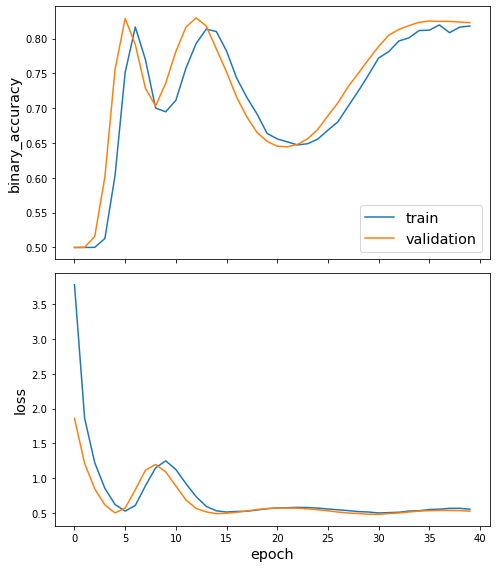

In [18]:
sg.utils.plot_history(history)

Evaluate the trained model on test citation links:

In [19]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 5ms/step - loss: 0.5260 - binary_accuracy: 0.8228

Train Set Metrics of the trained model:
	loss: 0.5333
	binary_accuracy: 0.8219

Test Set Metrics of the trained model:
	loss: 0.5260
	binary_accuracy: 0.8228
